In [76]:
import os
import json
import csv
import pandas as pd
import sys
import concurrent
import matplotlib.pyplot as plt

sys.path.append('../../../py/')
from GitManager import GitManager

root="/home/jovyan/work"
procesed_results_path=root+"/notebooks/ProjectAnalysis/TestAnalysis/results/"

In [2]:
ignored_android_projects = [
     'ActionBarSherlock',
     'roboguice',
     'android-Ultra-Pull-To-Refresh',
     'ViewPagerIndicator',
     'SlidingMenu',
     'NineOldAndroids',
     'ListViewAnimations',
     'Android-PullToRefresh',
     'ActiveAndroid',
     'android-common',
     'drag-sort-listview',
]
ignored_non_runnable_projects = [
    "guice",
    "Essentials",
    "neo4j",
    "spring-cloud-microservice-example",
    "canal",
    "hive",
    "spring-boot",
    "YCSB",
    "wildfly",
    "gephi",
    "deeplearning4j",
    "DataX",
    "netty",
    "hbase",
    "zheng",
    "openhab",
    "jstorm",
    "clojure",
    "learning-spark",
    "Mycat-Server" 
]
ignored_projects = ignored_android_projects + ignored_non_runnable_projects

In [21]:
path = root+"/configFiles/ManySStub4JProjects/"
projects = {}
for configFile in os.listdir(path):
    with open(path+configFile) as f:
        project_info = json.load(f)
        project_name = project_info["project"]
        if os.path.isdir(procesed_results_path+project_name) and project_name not in ignored_projects:
            projects[project_name] = project_info

In [4]:
projects.keys()

dict_keys(['flink', 'elastic-job', 'alluxio', 'dex2jar', 'jedis', 'android-volley', 'storm', 'dropwizard', 'titan', 'jsonschema2pojo', 'graylog2-server', 'spark', 'spring-security-oauth', 'auto', 'closure-compiler', 'dagger', 'java-design-patterns', 'crawler4j', 'apache-druid', 'otto', 'springside4', 'jfinal', 'hadoop', 'okhttp', 'twitter4j', 'fastjson', 'DiskLruCache', 'nanohttpd', 'atmosphere', 'presto', 'retrofit', 'guava', 'jsoup', 'disconf', 'antlr4', 'mybatis-3', 'javaee7-samples', 'pinpoint', 'FizzBuzzEnterpriseEdition', 'vert.x', 'swagger-codegen', 'HikariCP', 'checkstyle', 'Bukkit', 'cucumber-jvm', 'spring-petclinic', 'druid', 'swagger-core', 'metrics', 'dubbo', 'aws-sdk-java', 'Activiti', 'spring-mvc-showcase', 'zxing', 'HanLP', 'libgdx', 'ansj_seg', 'okio', 'javapoet', 'CoreNLP', 'camel', 'openmrs-core', 'scribejava', 'webmagic', 'async-http-client', 'junit'])

In [16]:
def getCommitsWithMaven(project):
    project_path = root+"/projects/"+project['project']
    gm = GitManager(project_path, project['last_commit'])
    commits = gm.getAllCommits()
    n_commits = len(commits)
    n_commits_with_pom = 0
    if os.path.isfile(procesed_results_path+project['project']+"/build-system.csv"):
        return project['project']
    with open(procesed_results_path+project['project']+"/build-system.csv", 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["commit_hash", "has_pom"])
        for c in commits:
            commit_hash = c.split("|=|")[0][1:]
            gm.change_commit(commit_hash)
            has_pom = os.path.isfile(project_path+"/pom.xml")
            writer.writerow((commit_hash, has_pom))
    return project['project']

In [20]:
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    future_results = []
    for project_info in projects.values():
        future_results.append(executor.submit(getCommitsWithMaven, project_info))
        #future_results.append(executor.submit(getCommitsWithMaven, projects['spring-petclinic']))
        #break
    for future in future_results:
        try:
            result = future.result()
            print("Finish "+result)
        except Exception as e:
            print("Error: ",e)

Finish flink
Finish elastic-job
Finish alluxio
Finish dex2jar
Finish jedis
Finish android-volley
Finish storm
Finish dropwizard
Finish titan
Finish jsonschema2pojo
Finish graylog2-server
Finish spark
Finish spring-security-oauth
Finish auto
Finish closure-compiler
Finish dagger
Finish java-design-patterns
Finish crawler4j
Finish apache-druid
Finish otto
Finish springside4
Finish jfinal
Finish hadoop
Finish okhttp
Finish twitter4j
Finish fastjson
Finish DiskLruCache
Finish nanohttpd
Finish atmosphere
Finish presto
Finish retrofit
Finish guava
Finish jsoup
Finish disconf
Finish antlr4
Finish mybatis-3
Finish javaee7-samples
Finish pinpoint
Finish FizzBuzzEnterpriseEdition
Finish vert.x
Finish swagger-codegen
Finish HikariCP
Finish checkstyle
Finish Bukkit
Finish cucumber-jvm
Finish spring-petclinic
Finish druid
Finish swagger-core
Finish metrics
Finish dubbo
Finish aws-sdk-java
Finish Activiti
Finish spring-mvc-showcase
Finish zxing
Finish HanLP
Finish libgdx
Finish ansj_seg
Finish okio


In [56]:
results = []
for project_info in projects.values():
    df = pd.read_csv(procesed_results_path+project_info['project']+"/build-system.csv")
    results.append([project_info['project'], len(df[df['has_pom']==True]), len(df), round(len(df[df['has_pom']==True])*100 / len(df), 2) ])
results_df = pd.DataFrame(results, columns = ['project', 'has_pom', 'total_commits','%'])

In [62]:
results_df['%'].mean()

88.78424242424242

In [63]:
results_df['%'].median()

98.99000000000001

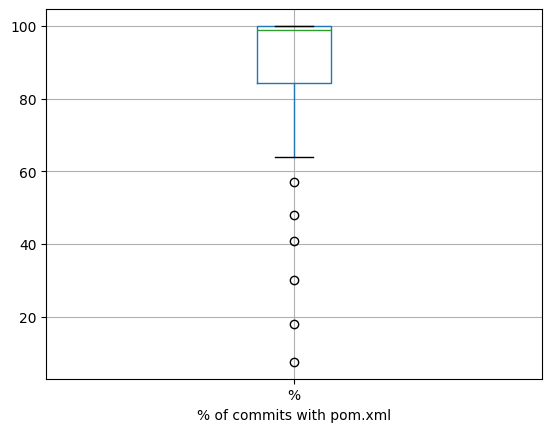

In [89]:
ax = results_df.boxplot(column='%')
ax.set_xlabel("% of commits with pom.xml")
plt.savefig("latex_figures/boxplot-commits-with-pom.pdf",bbox_inches='tight')
plt.show()

In [57]:
print("Projects with a % of maven commits greater that 90%", len(results_df[results_df['%'] >= 90]))
print("Projects with a % of maven commits greater that 90%", len(results_df[results_df['%'] < 90]))

Projects with a % of maven commits greater that 90% 47
Projects with a % of maven commits greater that 90% 19


In [58]:
results_df[results_df['%'] < 90]

,project,has_pom,total_commits,%
5,android-volley,146,1932,7.56
6,storm,8381,10440,80.28
10,graylog2-server,13902,19180,72.48
13,auto,1082,1297,83.42
14,closure-compiler,12749,17016,74.92
23,okhttp,3628,4861,74.63
33,disconf,946,1158,81.69
34,antlr4,5127,8026,63.88
38,FizzBuzzEnterpriseEdition,162,184,88.04
42,checkstyle,8161,10340,78.93


### Notes

#### Change from Ant/Gradle to Maven
- `android-volley` -> Change from Ant/Gradle to Maven
- `antlr4` -> Change from Ant to Maven
- `CoreNLP` -> Change from Ant/Gradle to Maven
- `openmrs-core`-> Change from Ant to Maven
- `junit` -> Change from Ant to Maven
- `libgdx` -> Change from Ant to Maven
- `ansj_seg`-> Change from Ant to Maven
- `checkstyle`-> Change from Ant to Maven
- `zxing` -> Change from Ant to Maven
  
#### Change from Maven to Gradle
- `okhttp`-> Change from Maven to Gradle

#### Introduce Maven (no previous build system)
- `storm`->  Introduce Maven (no previous build system)
- `graylog2-server`-> Introduce Maven (no previous build system)
- `metrics`-> Introduce Maven (no previous build system)
- `FizzBuzzEnterpriseEdition`-> Introduce Maven (no previous build system)

#### Other cases 
- `auto`-> Change from pom.xml to build-pom.xml. Now project consist on 4 individual Maven projects
- `closure-compiler`-> Change from build.xml to pom.xml and then change to Bazel (another build tool)
- `disconf`-> Use pom.xml, then use 6 different folders (with pom.xml) and then was re-estructured to have a common pom.xml
- `HanLP`-> Migrate from Java to Python
- `okio` -> pom.xml was located inside 'okio/' folder (not in root folder) - Nearly 99%

